In [25]:
#Read in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
#Read in data
%cd '/home/kishen/Documents/Projects/Customer Segmentation/data'

raw_data= pd.read_excel('Online Retail.xlsx', date_parser= 'InvoiceDate',dtype= {'CustomerID': 'object'})

/home/kishen/Documents/Projects/Customer Segmentation/data


**Preview and Inspect Data**

In [3]:
#Preview data
display(raw_data.shape)
raw_data.head()

(541909, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
#View Stats and data types
display(raw_data.info())
raw_data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


None

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


In [5]:
#Check missing values
raw_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Data Cleaning**

In [6]:
#Remove rows without a CustomerId
clean_df= raw_data.loc[~(raw_data.CustomerID.isna())]
                         
#Convert CustomerID to object                    
clean_df.loc[:, 'CustomerID']= clean_df['CustomerID'].astype('object')

/home/kishen/Documents/AcornAnalytics/SafeSport/safesport-notebook/venv/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Exploratory Data Analysis

What is the monthly revenue of the business?

In [7]:
#Create df and extract time series data for capturing metrics of interest
metrics= clean_df.copy()
metrics.loc[:, 'MonthYear']= metrics['InvoiceDate'].dt.to_period('M')

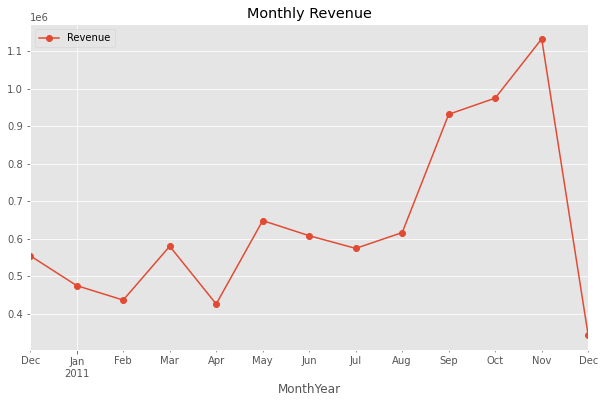

In [8]:
#Calculate monthly revenue
metrics.loc[:, 'Revenue']= metrics['Quantity'] * metrics['UnitPrice']
monthlyRevenue= metrics.groupby('MonthYear')['Revenue'].sum().reset_index()

#Plot Data
f, ax= plt.subplots(figsize= (10,6))
monthlyRevenue.plot(x='MonthYear', y='Revenue',
                    ax=ax, marker='o')
ax.set_title('Monthly Revenue');

What is the monthly revenue growth rate of the business?

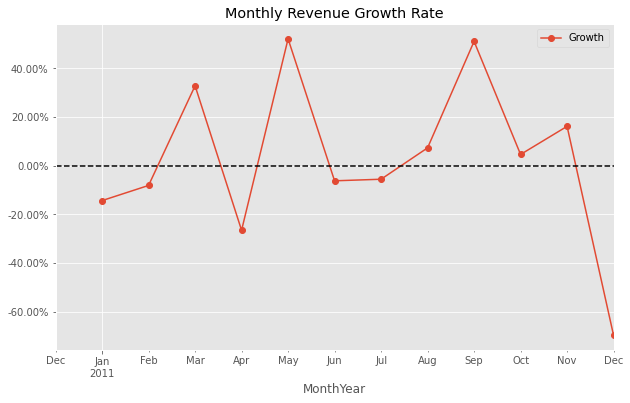

In [9]:
#Calculate % change between revenue for each month
monthlyRevenue.loc[:, 'monthlyGrowthRate']= monthlyRevenue['Revenue'].pct_change()

#Plot Data
f, ax= plt.subplots(figsize= (10,6))
monthlyRevenue.plot(x='MonthYear', y= 'monthlyGrowthRate', 
                    ax=ax, marker='o', label= 'Growth')

#PLot 0 as reference
ax.axhline(y=0, color = 'black', linestyle= '--')

#Set aesthetics
ax.set_title('Monthly Revenue Growth Rate')
vals = ax.get_yticks()
ax.set_yticklabels(['{:.2%}'.format(x) for x in vals]);

How many active customers do we have per month? How about the number of monthly orders?

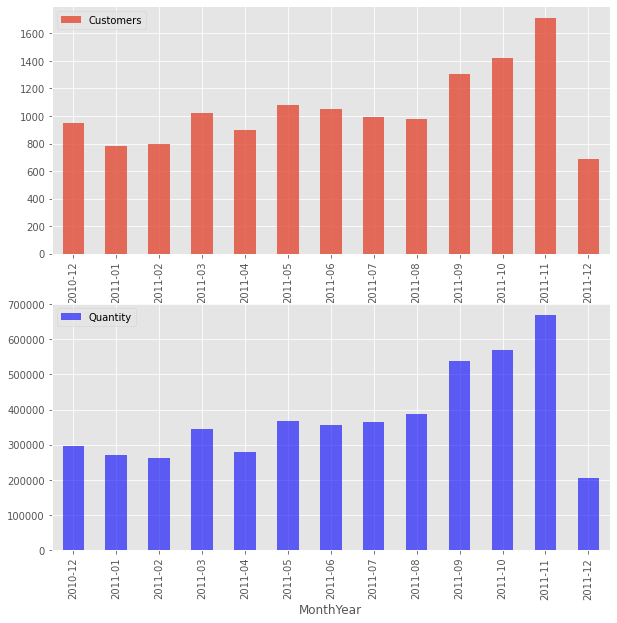

In [10]:
#Prep data
activeCustomers= metrics.groupby(['MonthYear'])['CustomerID'].nunique().reset_index()
monthlyOrders= metrics.groupby('MonthYear')['Quantity'].sum().reset_index()

f, ax= plt.subplots(2,1,figsize = (10,10))

activeCustomers.plot(x='MonthYear', y= 'CustomerID', 
               alpha=.8, kind='bar', 
               label= 'Customers', ax= ax[0])

monthlyOrders.plot(x='MonthYear', y= 'Quantity', 
                   color='blue', alpha=.6, kind='bar', ax=ax[1])

What is the new customer ratio?

A customer will be defined as new when it is their first time making a purchase. All subsequent transactions from the users will be identified as existing

In [11]:
#Get date for when each customer would be a new customer
newCustomers= metrics.groupby('CustomerID')['InvoiceDate'].min().reset_index()
newCustomers.columns= ['CustomerID', 'FirstInvoice']

#Merge FirstInvoice to metrics
metrics= metrics.merge(newCustomers, left_on='CustomerID', right_on='CustomerID')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,MonthYear,Revenue,FirstInvoice
204592,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011-01,77183.60,2011-01-18 10:01:00
204593,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,2011-01,-77183.60,2011-01-18 10:01:00
101409,537626,84558A,3D DOG PICTURE PLAYING CARDS,24,2010-12-07 14:57:00,2.95,12347,Iceland,2010-12,70.80,2010-12-07 14:57:00
101466,556201,23162,REGENCY TEA STRAINER,8,2011-06-09 13:01:00,3.75,12347,Iceland,2011-06,30.00,2010-12-07 14:57:00
101465,556201,23084,RABBIT NIGHT LIGHT,12,2011-06-09 13:01:00,2.08,12347,Iceland,2011-06,24.96,2010-12-07 14:57:00


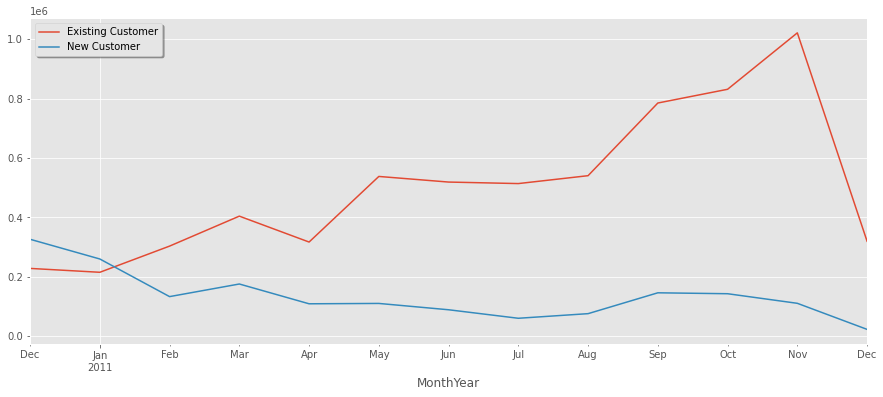

In [44]:
#Flag customers as new or existing based on condition
metrics['CustomerStatus'] = np.where(metrics['InvoiceDate']== metrics['FirstInvoice'],
                                     'New Customer',
                                     'Existing Customer')

#Calculate revenue for new and existing customers
customerRevenue= metrics.groupby(['MonthYear','CustomerStatus'])['Revenue'].sum().reset_index()
existingRevenue= customerRevenue.loc[customerRevenue['CustomerStatus'] == 'Existing Customer', :]
newRevenue= customerRevenue.loc[customerRevenue['CustomerStatus'] == 'New Customer', :]


#Visualize data
f, ax= plt.subplots(figsize= (15,6))

existingRevenue.plot(x= 'MonthYear', y= 'Revenue',
                     label= 'Existing Customer', ax= ax)
newRevenue.plot(x= 'MonthYear', y= 'Revenue',
                label= 'New Customer', ax= ax)

ax.legend(shadow= True)

Let's look at the above as a barplot

In [49]:
j= customerRevenue.pivot(index= 'MonthYear', columns= 'CustomerStatus', values= 'Revenue' )

j['New Customer Ratio']= j['New Customer']/j['Existing Customer']

In [52]:
j

CustomerStatus,Existing Customer,New Customer,New Customer Ratio
MonthYear,,,
2010-12,228215.060,326388.960,1.430182
2011-01,215147.020,259927.360,1.208138
2011-02,303359.430,133186.720,0.439039
2011-03,404289.150,175675.460,0.434529
2011-04,317042.050,109005.801,0.343821
2011-05,538047.580,110203.500,0.204821
2011-06,519129.490,88883.670,0.171217
2011-07,514025.120,60213.361,0.117141
2011-08,540605.450,75762.550,0.140144


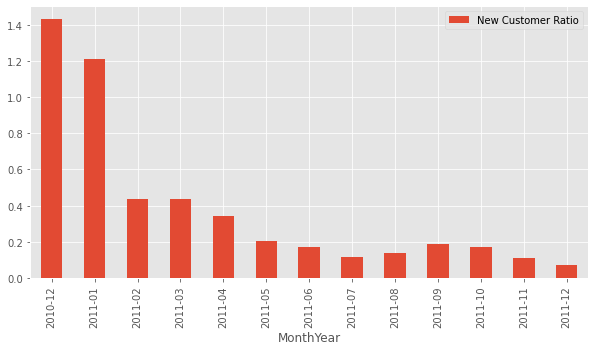

In [56]:
j.plot(y ='New Customer Ratio', kind= 'bar', figsize= (10,5))
